In [0]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy.fftpack import dct
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from  sklearn.linear_model import LogisticRegression
from  sklearn.tree import  DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier 

In [0]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 3157, done.
remote: Total 3157 (delta 0), reused 0 (delta 0), pack-reused 3157
Receiving objects: 100% (3157/3157), 23.91 MiB | 8.47 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [0]:
#!ls free-spoken-digit-dataset/recordings
catalog_name = './free-spoken-digit-dataset/recordings/'
sample = 8000
record_len = 10000

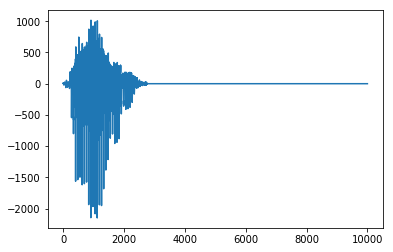

In [0]:
#raw data
X_raw_data = np.ndarray((2000,record_len))
y = np.ndarray((2000,1))
i=0
list_avg = []
for fn in os.listdir(catalog_name):
  new_record = scipy.io.wavfile.read(catalog_name+fn)[1]
  if (len(new_record) < record_len):
    time_differece = record_len - len(new_record)
    new_record = np.append(new_record,np.zeros((time_differece)))
  else:
    new_record = new_record[:record_len]  
  X_raw_data[i]=  new_record
  y[i] = fn[0]
  i+=1
plt.plot(X_raw_data[910])

In [0]:

#framing
frame_size = 0.025
frame_stride = 0.01
sample_rate = 8000
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
#X_preemphased_cp = np.copy(X_preemphased)
X_preemphased_cp=X_raw_data
X_frames = np.zeros((2000,123,200))
for i in range(len(X_preemphased_cp)):
  signal_length = len(X_preemphased_cp[i])
  frame_length = int(round(frame_length))
  frame_step = int(round(frame_step))
  num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

  pad_signal_length = num_frames * frame_step + frame_length
  z = np.zeros((pad_signal_length - signal_length))
  pad_signal = np.append(X_preemphased_cp[i], z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

  indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
  X_frames[i] = pad_signal[indices.astype(np.int32, copy=False)]



In [0]:
#Hamming
X_ham = np.copy(X_frames)
for i in range(len(X_ham)):
  X_ham[i] *= np.hamming(frame_length)

In [0]:
#Fourier-transform and power spectrum
NFFT = 512
X_ft = np.copy(X_ham)
mag_frames = np.zeros((2000,123,257))
pow_frames = np.zeros((2000,123,257))
for i in range(len(X_ft)):
  mag_frames[i] = np.absolute(np.fft.rfft(X_ft[i], NFFT))  # Magnitude of the FFT
  pow_frames[i] = ((1.0 / NFFT) * ((mag_frames[i]) ** 2))  # Power Spectrum

In [0]:
#filter banks
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)
fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks  = np.zeros((2000,123,40))     
for i in range(len(pow_frames)):  
  filter_banks[i] = np.dot(pow_frames[i], fbank.T)
  filter_banks[i] = np.where(filter_banks[i] == 0, np.finfo(float).eps, filter_banks[i])  # Numerical Stability
  filter_banks[i] = 20 * np.log10(filter_banks[i])  # dB


(2000, 12, 40)


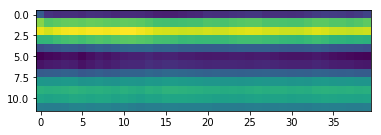

In [0]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
print( mfcc.shape)
_, nframes, ncoeff = mfcc.shape
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
plt.imshow(mfcc[9])

In [0]:
#X = np.zeros((2000,4920))
X = np.zeros((2000,480))
for i in range(len(filter_banks)):
  #X[i] = filter_banks[i].flatten()
  X[i] = mfcc[i].flatten()

In [0]:
y = y.squeeze()
LR_model = LogisticRegression(random_state=13, solver='lbfgs', max_iter=3000, multi_class='multinomial')
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
LR_model.fit(X_train,y_train)
    

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=13, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

0.9575


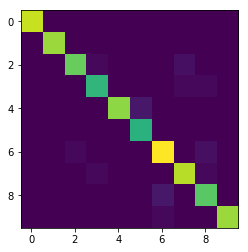

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(y_test, LR_model.predict(X_test)))
plt.imshow(confusion_matrix(y_test, LR_model.predict(X_test)))

0.6275


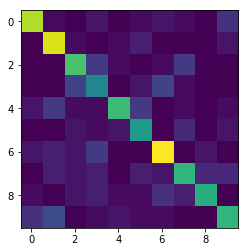

In [0]:
DT_model = DecisionTreeClassifier(max_depth=90,criterion='entropy') 
DT_model.fit(X_train,y_train)
print(accuracy_score(y_test, DT_model.predict(X_test)))
plt.imshow(confusion_matrix(y_test, DT_model.predict(X_test)))

0.8575


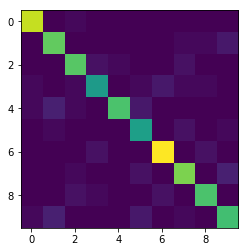

In [0]:
RF_model = RandomForestClassifier(criterion='entropy', bootstrap=False, n_estimators=200, n_jobs = -1)
RF_model.fit(X_train,y_train)
print(accuracy_score(y_test, RF_model.predict(X_test)))
plt.imshow(confusion_matrix(y_test, RF_model.predict(X_test)))



In [0]:
GB_model = GradientBoostingClassifier()
GB_model.fit(X_train,y_train)
print(accuracy_score(y_test, GB_model.predict(X_test)))
plt.imshow(confusion_matrix(y_test, GB_model.predict(X_test)))

In [0]:
print((y[0]))

In [0]:
Y_test = np.zeros((np.size(y_test),1))
Y_train= np.zeros((np.size(y_train),1))
for i in range(np.size(y_test)):
  Y_test[i] = y_test[i]
for i in range(np.size(Y_train)):
  Y_train[i] = y_train[i]  

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torch.optim as optim


In [0]:
class my_data():
    def __init__(self,X,Y):
        self.data = X  # 1st and 2nd columns --> x,y
        self.target = Y# 3nd column --> label
        self.n_samples = self.data.shape[0]
    
    def __len__(self):   # Length of the dataset.
        return self.n_samples
    
    def __getitem__(self,index):   # Function that returns one point and one label.
        return torch.Tensor(self.data[index]), torch.Tensor(self.target[index])
dat = my_data(X_train,Y_train)
train_loader = data.DataLoader(dat,batch_size=50)
dat = my_data(X_test,Y_test)
test_loader = data.DataLoader(dat,batch_size=50)

In [0]:
class NeuralNet(nn.Module):
  def __init__(self, input_size,first_size,sec_size,third_size,output_size):
      super(NeuralNet, self).__init__()
      self.layer1 = nn.Linear(input_size, first_size)
      self.layer2 = nn.Linear(first_size, sec_size)
      self.layer3 = nn.Linear(sec_size, third_size)
      self.layer4 = nn.Linear(third_size, output_size)
      self.relu = nn.ReLU()
	
  def forward(self, x):
      output = self.layer1(x)
      output = self.relu(output)
      output = self.layer2(output)
      output = self.relu(output)
      output = self.layer3(output)
      output = self.relu(output)
      output = self.layer4(output)
      return output

In [0]:
input_size = 480
first_size = 1400
sec_size = 2500
third_size = 1400
output_size = 10
num_epochs = 150

learning_rate = 1e-4

model = NeuralNet(input_size,first_size,sec_size,third_size,output_size)

lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,amsgrad=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)

In [0]:
def eval_test(model,test_loader):
# run a test loop
  test_loss = 0
  correct = 0
  for i, (data,labels) in enumerate(test_loader):
      labels = labels.view(-1).long()
      net_out = model(data)
      # sum up batch loss
      test_loss += lossFunction(net_out, labels).data
      pred = net_out.data.max(1)[1]  # get the index of the max log-probability
      correct += pred.eq(labels.data).sum()

  test_loss /= len(test_loader.dataset)
  print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format( test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [0]:
total_step = len(train_loader)
for epoch in range(num_epochs):
	for i, (data,labels) in enumerate(train_loader):
		labels = labels.view(-1).long()
		out = model(data)
		loss = lossFunction(out,labels)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if (i+1) % 32 == 0:
			print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
	eval_test(model,test_loader)


Epoch [1/150], Step [32/32], Loss: 3.3181
Test set: Average loss: 0.0679, Accuracy: 150/400 (37%)

Epoch [2/150], Step [32/32], Loss: 0.9128
Test set: Average loss: 0.0406, Accuracy: 222/400 (55%)

Epoch [3/150], Step [32/32], Loss: 0.5458
Test set: Average loss: 0.0264, Accuracy: 262/400 (65%)

Epoch [4/150], Step [32/32], Loss: 0.3971
Test set: Average loss: 0.0184, Accuracy: 301/400 (75%)

Epoch [5/150], Step [32/32], Loss: 0.2603
Test set: Average loss: 0.0156, Accuracy: 316/400 (79%)

Epoch [6/150], Step [32/32], Loss: 0.1942
Test set: Average loss: 0.0156, Accuracy: 307/400 (76%)

Epoch [7/150], Step [32/32], Loss: 0.2845
Test set: Average loss: 0.0147, Accuracy: 316/400 (79%)

Epoch [8/150], Step [32/32], Loss: 0.1961
Test set: Average loss: 0.0177, Accuracy: 297/400 (74%)

Epoch [9/150], Step [32/32], Loss: 0.0911
Test set: Average loss: 0.0170, Accuracy: 318/400 (79%)

Epoch [10/150], Step [32/32], Loss: 0.2141
Test set: Average loss: 0.0141, Accuracy: 328/400 (82%)

Epoch [11